# ESA Worldcover extraction for grid proportions and tiles export
Based on Locally Downloaded ESA Worldcover tiles in wgs84, we calculate using dask the proportions of landcover values within each grid cell

In [ ]:
# Modified Code to work on RAW 1922 tif files from Google Earth Engine
import os
os.environ["OMP_NUM_THREADS"] = '2'

import glob
import gc
import geopandas as gpd
import numpy as np
import rasterio
from shapely.geometry import box
from shapely.ops import unary_union
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
from rasterio.windows import from_bounds
from rasterio.features import geometry_mask
from rasterio import warp
from collections import Counter
from dask.distributed import Client, LocalCluster
import dask_geopandas as dgpd
import pandas as pd
from tqdm import tqdm
import warnings
from time import time, strftime, localtime
from sklearn.cluster import KMeans
import dask
from dask import delayed
import tempfile
from osgeo import gdal
import rasterio

warnings.filterwarnings("ignore", message="'GeoDataFrame.swapaxes' is deprecated")

def spatial_kmeans_partition(gdf, n_clusters=20, random_state=42):
    """Cluster polygons spatially using centroid coordinates."""
    centroids = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto').fit(centroids)
    gdf["cluster"] = kmeans.labels_
    
    partitions = [gdf[gdf["cluster"] == k].drop(columns="cluster") for k in range(n_clusters)]
    return partitions


def calculate_landcover_proportions(masked_data):
    lc_values = masked_data.flatten()
    lc_values = lc_values[lc_values != 1]
    if lc_values.max() == 0:
        return {0: 1.0}
    total_pixels = lc_values.size
    lc_counts = dict(Counter(lc_values))
    lc_proportions = {int(k): round(v / total_pixels, 5)
                        for k, v in lc_counts.items() }
    # Uncomment for debugging non-zero classes
    # if any(k != 0 for k in lc_proportions.keys()):
    #     print(f"Non-zero classes found: {lc_proportions}")

    return lc_proportions



@delayed
def process_partition(partition_gdf, raster_path, dst_crs, resolution, zone_name, max_pixels=1e12, raster_outline_gdf=None):
    if len(partition_gdf) == 0:
        raise ValueError("Empty partition received.")

    minx, miny, maxx, maxy = partition_gdf.total_bounds
    width_utm = maxx - minx
    height_utm = maxy - miny
    out_width = int(round(width_utm / resolution))
    out_height = int(round(height_utm / resolution))

    if (out_width * out_height) > max_pixels or out_width < 1 or out_height < 1:
        raise RuntimeError(f"**WARNING**: Bounding box too large or degenerate: {out_width}×{out_height}")

    snapped_maxx = minx + out_width * resolution
    snapped_maxy = maxy
    dst_transform = rasterio.Affine(resolution, 0, minx, 0, -resolution, snapped_maxy)
    src_bounds = warp.transform_bounds(dst_crs, "EPSG:4326", minx, miny, snapped_maxx, maxy)
    try:
        utm_zone_number = int(zone_name[:-1])
    except:
        utm_zone_number = zone_name[0:2]
    
    if zone_name in ["1N", "1S", "60N", "60S"]:
        zone_west = -179.999 + (utm_zone_number - 1) * 6
        zone_east = zone_west + 5.9999
        print(f"Clamping src_bounds for {zone_name} to {zone_west}–{zone_east}")
        # Clamp the WGS84 bounds to the UTM zone
        src_bounds = (max(src_bounds[0], zone_west), src_bounds[1],
            min(src_bounds[2], zone_east), src_bounds[3])
        if (src_bounds[2] - src_bounds[0]) > 10:
            raise RuntimeError(f"Clamped longitude range too wide: {src_bounds}")
        
    # For south polar zone SP, need to clamp the latitude bounds
    if zone_name == "SP":
        zone_south = -89.5
        zone_north = 90.0
        print(f"Clamping src_bounds for {zone_name} to {zone_south}–{zone_north}")
        # Clamp the WGS84 bounds to the UTM zone
        src_bounds = (src_bounds[0], max(src_bounds[1], zone_south),
            src_bounds[2], min(src_bounds[3], zone_north))
        if (src_bounds[3] - src_bounds[1]) > 10:
            raise RuntimeError(f"Clamped latitude range too wide: {src_bounds}")
    # For norht polar zone NP, also, need to clamp the latitude bounds
    if zone_name == "NP":
        zone_south = 0.0
        zone_north = 89.5
        print(f"Clamping src_bounds for {zone_name} to {zone_south}–{zone_north}")
        # Clamp the WGS84 bounds to the UTM zone
        src_bounds = (src_bounds[0], max(src_bounds[1], zone_south),
            src_bounds[2], min(src_bounds[3], zone_north))
        if (src_bounds[3] - src_bounds[1]) > 10:
            raise RuntimeError(f"Clamped latitude range too wide: {src_bounds}")

    proportions = []
    resampling = Resampling.nearest if resolution <= 10 else Resampling.mode

    # === CASE 1: Mosaic TIF ===
    if os.path.isfile(raster_path) and raster_outline_gdf is None:
        with rasterio.open(raster_path) as src:
            vrt_options = {
                "crs": dst_crs,
                "transform": dst_transform,
                "width": out_width,
                "height": out_height,
                "blockxsize": 512,
                "blockysize": 512,
                "resampling": resampling,
                "src_bounds": src_bounds,
                "src_nodata": src.nodata,
                "count": 1
            }

            with WarpedVRT(src, **vrt_options) as vrt:
                for idx, row in partition_gdf.iterrows():
                    poly = row.geometry
                    tile_id = row["tile_id"]
                    pminx, pminy, pmaxx, pmaxy = poly.bounds
                    window = from_bounds(pminx, pminy, pmaxx, pmaxy, transform=dst_transform)

                    try:
                        data = vrt.read(1, window=window)
                    except Exception as e:
                        print("Breaking")
                        print(f"Sub-window read failed for {tile_id}: {e}")
                        raise RuntimeError("Raster read failed.")

                    mask_arr = rasterio.features.geometry_mask(
                        [poly.__geo_interface__],
                        transform=vrt.window_transform(window),
                        invert=True,
                        out_shape=data.shape
                    )
                    data[~mask_arr] = 1
                    prop_dict = calculate_landcover_proportions(data)
                    proportions.append((tile_id, prop_dict))

    # === CASE 2: Multiple Raster Tiles ===
    elif os.path.isdir(raster_path) and raster_outline_gdf is not None:
        selected = raster_outline_gdf.cx[src_bounds[0]:src_bounds[2], src_bounds[1]:src_bounds[3]]
        raster_names = selected["raster_fil"].unique().tolist()
        raster_paths = [os.path.join(raster_path, f) for f in raster_names if os.path.exists(os.path.join(raster_path, f))]

        if not raster_paths:
            proportions = partition_gdf[["tile_id"]].copy()
            proportions["landcover_props"] = ["{0: 1.0}"] * len(proportions)
            result_df = pd.DataFrame(proportions, columns=["tile_id", "landcover_props"])
            return result_df
            # raise RuntimeError(f"No input rasters found for bounds: {src_bounds}")

        # if not raster_paths:
        #     raise RuntimeError(f"No input rasters found for bounds: {src_bounds}")

        with tempfile.NamedTemporaryFile(suffix=".vrt", delete=False) as tmp_vrt:
            vrt_path = tmp_vrt.name

        gdal.BuildVRT(vrt_path, raster_paths)

        with rasterio.open(vrt_path) as src:
            vrt_options = {
                "crs": dst_crs,
                "transform": dst_transform,
                "width": out_width,
                "height": out_height,
                "blockxsize": 512,
                "blockysize": 512,
                "resampling": resampling,
                "src_bounds": src_bounds,
                "src_nodata": src.nodata,
                "count": 1
            }

            with WarpedVRT(src, **vrt_options) as vrt:
                for idx, row in partition_gdf.iterrows():
                    poly = row.geometry
                    tile_id = row["tile_id"]
                    pminx, pminy, pmaxx, pmaxy = poly.bounds
                    window = from_bounds(pminx, pminy, pmaxx, pmaxy, transform=dst_transform)

                    try:
                        data = vrt.read(1, window=window)
                    except Exception as e:
                        print("Breaking")
                        print(f"Sub-window read failed for {tile_id}: {e}")
                        raise RuntimeError("Raster read failed.")

                    mask_arr = rasterio.features.geometry_mask(
                        [poly.__geo_interface__],
                        transform=vrt.window_transform(window),
                        invert=True,
                        out_shape=data.shape
                    )
                    data[~mask_arr] = 1
                    prop_dict = calculate_landcover_proportions(data)
                    proportions.append((tile_id, prop_dict))

        os.remove(vrt_path)

    else:
        raise ValueError("Invalid raster_path and raster_outline_gdf combination.")

    result_df = pd.DataFrame(proportions, columns=["tile_id", "landcover_props"])
    return result_df


def run_zone(zone_name, gdf, raster_path, resolution=10, partition_size=1000, 
             max_pixels=1e12, raster_outline_gdf=None, n_workers=10, memory_limit="2.5GB"):

    if not gdf.crs.is_projected:
        raise ValueError(f"{zone_name} CRS must be projected (e.g., UTM). Got: {gdf.crs}")
    
    dst_crs = gdf.crs
    num_partitions = max(1, len(gdf) // partition_size)
    start = time()
    partitions = spatial_kmeans_partition(gdf, n_clusters=num_partitions)
    end = time()
    print(f"Time for clustering: {end - start:.2f} seconds")

    dask.config.set({
        "distributed.worker.memory.target": 0.98,
        "distributed.worker.memory.spill": 0.98,
        "distributed.worker.memory.pause": 0.98,
    })

    cluster = LocalCluster(n_workers=n_workers, threads_per_worker=1, memory_limit=memory_limit)
    client = Client(cluster)
    print("Dask Dashboard Link: ", client.dashboard_link)

    try:
        futures = client.scatter(partitions, broadcast=False)

        tasks = [
            process_partition(fut, raster_path, dst_crs, resolution, zone_name,
                              max_pixels=max_pixels, raster_outline_gdf=raster_outline_gdf)
            for fut in futures
        ]

        results = dask.compute(*tasks)  # No big gather on a single worker
        df = pd.concat(results, ignore_index=True)

    finally:
        client.close()
        cluster.close()

    return df


In [ ]:
# Entry-point for batch run
zones = [f"{i}{d}" for i in range(1, 61) for d in ["N", "S"]]
grid_size = 1200
resolution = 10
n_workers = 8
process_mosaic = False
raster_dir = r"F:/ESA_LC_Raw"

default_levels = [300, 600, 1200, 2400, 12000, 120000]
i = default_levels.index(grid_size)
if (i+1) < len(default_levels):
    super_grid_size = default_levels[i + 1]
else:
    super_grid_size=None
print("super_grid_size: ", super_grid_size)

grid_dir = f"D:/NestEO_test_outputs/grid_{grid_size}m"
super_dir = f"D:/NestEO_test_outputs/grid_{super_grid_size}m"

zones = ["SP", "NP"]

for zone in zones:
    # if zone in ["1N", "1S", "60N", "60S"]:
    #     continue
    # if "N" in zone:
    #     continue
    st = time()
    out_file = os.path.join(grid_dir, f"lc_proportions_{resolution}m_{zone}_{grid_size}m.parquet")
    print(out_file)

    if os.path.exists(out_file):
        print("\nSkipping, file exists: ", out_file)
        continue

    if process_mosaic:
        raster_path = os.path.join(raster_dir, f"ESA_LC_UTM_zone_{zone}_grid.tif")
        raster_outline_gdf = None
    else:
        raster_path = raster_dir
        raster_outline_gdf = gpd.read_file("F:/ESA_LC_Raw/raster_outlines.shp")
        print("\nTotal tiles: ", len(raster_outline_gdf))

    if not os.path.exists(raster_path):
        print("\nNOT FOUND: ", raster_path)
        continue
    print("\nProcessing zone:", zone)
    parquet_file = os.path.join(grid_dir, f"grid_{zone}_{grid_size}.parquet")
    if os.path.exists(parquet_file):
        gdf = gpd.read_parquet(parquet_file)[["tile_id", "super_id", "geometry"]].copy()
    else:
        raise ValueError(f"{parquet_file} grid file not found..")
    # Make use of the heirarchy and nesting    
    if super_grid_size:
        super_result_file = os.path.join(super_dir, f"lc_proportions_{resolution}m_{zone}_{super_grid_size}m.parquet")
        # print(super_result_file)
        if not os.path.exists(super_result_file):
            raise ValueError(f"Missing super-level results: {super_result_file}")
        super_df = pd.read_parquet(super_result_file)
        super_zero_tiles = set(
            super_df.loc[super_df["landcover_props"] == "{0: 1.0}", "tile_id"]
        )
    else:
        super_zero_tiles = set()


    if super_zero_tiles:
        zero_gdf = gdf[gdf["super_id"].isin(super_zero_tiles)].copy()
        non_zero_gdf = gdf[~gdf["super_id"].isin(super_zero_tiles)].copy()
    else:
        zero_gdf = gdf.iloc[0:0]  # Empty
        non_zero_gdf = gdf.copy()
    if zone in ["1N", "1S", "60N", "60S", "SP", "NP"]:
        # Area-based filtering useful for border zones
        max_area = 2 * grid_size * grid_size  # Dynamic threshold based on grid resolution (in meters)
        non_zero_gdf["area"] = non_zero_gdf.geometry.area
        oversized_gdf = non_zero_gdf[non_zero_gdf["area"] > max_area].copy()
        non_zero_gdf = non_zero_gdf[non_zero_gdf["area"] <= max_area].copy()
        print("Oversized excluded: ", len(oversized_gdf), "remaining: ", len(non_zero_gdf))
        # Assign placeholder landcover proportions to oversized polygons
        oversized_gdf["landcover_props"] = ["{-1: 1.0}"] * len(oversized_gdf)
        oversized_df = oversized_gdf[["tile_id", "landcover_props"]]
    else:
        oversized_df = pd.DataFrame(columns=["tile_id", "landcover_props"])
    total_cells = len(gdf)
    # gdf = gpd.read_parquet(parquet_file)[["tile_id", "super_id", "geometry"]].copy()
    total_cells = len(gdf)
    non_zero_cells = len(non_zero_gdf)
    print(f"The zero records: {len(zero_gdf)}, The non-zero records: {non_zero_cells}")
    print(f"Percent processing: {non_zero_cells/total_cells*100}%")

    del super_zero_tiles  # Clean up memory
    gc.collect()

    
    large_factor = round((1/np.sqrt(grid_size)*100)+1, 0)

    ##################################################################################################
    # partition_size = min(partition_size, len(non_zero_gdf))
    partition_factor = n_workers*5*large_factor
    partition_size = int(non_zero_cells//partition_factor)+1
    memory_limit = f"{42.0/n_workers}GB"
    print("partition_size: ", partition_size, "memory_limit: ", memory_limit)
    df = run_zone(zone, non_zero_gdf, raster_path, resolution=resolution, partition_size=partition_size, 
             max_pixels=1e12, raster_outline_gdf=raster_outline_gdf, n_workers=n_workers, memory_limit=memory_limit)


    #################################################################################################


    # df = run_zone(zone, non_zero_gdf, raster_file, resolution=resolution, partition_size=partition_size)

    zero_gdf["landcover_props"] = ["{0: 1.0}"] * len(zero_gdf)
    zero_df = zero_gdf[["tile_id", "landcover_props"]]  # keep only required columns

    # Final full DataFrame
    df = pd.concat([df, zero_df], ignore_index=True)
    df["landcover_props"] = df["landcover_props"].astype(str)
    df.to_parquet(out_file, index=False, compression='snappy')
    # df.to_csv(out_file, index=False)

    assert len(df["tile_id"].unique()) == len(gdf["tile_id"].unique()), "Mismatch in tile counts!"
    print(f"Processed zone: {zone} in {(time()-st)/60} mins at {strftime('%H:%M:%S', localtime())}")

    del gdf, df  # or any large objects
    gc.collect()


super_grid_size:  1200
D:/NestEO_test_outputs/grid_600m\lc_proportions_10m_SP_600m.parquet

Total tiles:  1922

Processing zone: SP
Oversized excluded:  0 remaining:  780
The zero records: 6704, The non-zero records: 780
Percent processing: 10.42223409941208%
partition_size:  4 memory_limit:  5.25GB
Time for clustering: 0.49 seconds
Dask Dashboard Link:  http://127.0.0.1:8787/status
Processed zone: SP in 0.1368504484494527 mins at 21:53:06
D:/NestEO_test_outputs/grid_600m\lc_proportions_10m_NP_600m.parquet

Total tiles:  1922

Processing zone: NP
Oversized excluded:  0 remaining:  400
The zero records: 4348, The non-zero records: 400
Percent processing: 8.424599831508003%
partition_size:  3 memory_limit:  5.25GB
Time for clustering: 0.18 seconds
Dask Dashboard Link:  http://127.0.0.1:8787/status
Processed zone: NP in 0.10280503829320271 mins at 21:53:12


# Exporting ESA LC tiles

### For the selected 1200m grid cells

In [ ]:
# -*- coding: utf-8 -*-
"""
Extract 120 × 120 ESA WorldCover subsets for each 1 200 m NestEO grid cell,
compute per-class proportions, compress the array, and write one Parquet per
UTM/polar zone.

Keeps the structure of the user’s working script; only adds automatic VRT
generation and compressed byte storage.

Dependencies:
    geopandas 0.14+, rasterio 1.3+, GDAL 3.6+, dask 2024.x, pyarrow 15+
"""

# ────────────────────────── USER SETTINGS ──────────────────────────
GRID_PATH           = r"D:/NestEO_test_outputs/Selected_1200m_grid.parquet"   # WGS84 geometry + epsg + utm_footprint
RASTER_DIR          = r"F:/ESA_LC_Raw"                                # ≈1 922 GeoTIFF tiles
RASTER_OUTLINE_SHP  = r"F:/ESA_LC_Raw/raster_outlines.shp"            # must contain 'raster_fil' column
OUTPUT_ROOT         = r"D:/NestEO_test_outputs/esa_lc_tiles_1200m"                 # one Parquet per EPSG zone
RESOLUTION_M        = 10                                              # 10 m → 120 × 120 px
PARTITION_SIZE      = 5_000                                           # k-means partition size
N_WORKERS           = 10
MEM_LIMIT           = "2.5GB"
OMP_THREADS         = 2
# ────────────────────────────────────────────────────────────────────

import os, json, zlib, tempfile, gc, warnings, dask
os.environ["OMP_NUM_THREADS"] = str(OMP_THREADS)

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkt
from sklearn.cluster import KMeans
from collections import Counter
from dask.distributed import LocalCluster, Client
from dask import delayed
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
from rasterio.windows import from_bounds
from rasterio.features import geometry_mask
from rasterio import warp
from osgeo import gdal

warnings.filterwarnings("ignore", category=UserWarning, module="geopandas")
import os
os.environ["OMP_NUM_THREADS"] = '1'

# ────────────────────── HELPER FUNCTIONS ──────────────────────
def _compress(arr: np.ndarray, lvl: int = 3) -> bytes:
    """zstd-compress a uint8 array to bytes."""
    return zlib.compress(arr.tobytes(), level=lvl)


def _calc_props(arr: np.ndarray) -> dict:
    """Return {class: proportion}, skipping mask value 1."""
    flat = arr.ravel()
    flat = flat[flat != 1]                # 1 = artificial outside mask
    if flat.size == 0:
        return {0: 1.0}
    tot = flat.size
    cnt = Counter(flat.astype("uint8"))
    return {int(k): round(v / tot, 5) for k, v in cnt.items()}


def _kmeans_partitions(gdf: gpd.GeoDataFrame, max_sz: int):
    """Split GeoDataFrame into balanced spatial clusters."""
    n_cls = max(1, len(gdf) // max_sz)
    cent = np.column_stack([gdf.geometry.centroid.x, gdf.geometry.centroid.y])
    lbls = KMeans(n_clusters=n_cls, n_init="auto", random_state=42).fit(cent).labels_
    gdf = gdf.copy(); gdf["_c"] = lbls
    return [gdf[gdf._c == k].drop(columns="_c") for k in range(n_cls)]


# ─────────────────── CORE PARTITION PROCESSOR ───────────────────
@delayed
def _process_partition(part_gdf: gpd.GeoDataFrame,
                       raster_dir: str,
                       outline_gdf: gpd.GeoDataFrame,
                       dst_crs: str,
                       res_m: float,
                       max_pixels: int = 1_000_000_000) -> pd.DataFrame:
    """Warp WorldCover, clip every tile polygon, compute proportions."""
    if part_gdf.empty:
        return pd.DataFrame(columns=["tile_id", "landcover_props", "esa_lc"])

    # Build a warp grid covering the whole partition
    minx, miny, maxx, maxy = part_gdf.total_bounds
    width  = int(round((maxx - minx) / res_m))
    height = int(round((maxy - miny) / res_m))
    # if width * height > max_pixels:
    #     raise RuntimeError("Partition too large; increase PARTITION_SIZE.")

    dst_transform = rasterio.Affine(res_m, 0, minx, 0, -res_m, maxy)
    # Bounding box in WGS 84 for selecting raster tiles
    src_bounds = warp.transform_bounds(dst_crs, "EPSG:4326",
                                       minx, miny, maxx, maxy)

    # Find GeoTIFFs intersecting the partition
    sel = outline_gdf.cx[src_bounds[0]:src_bounds[2],
                         src_bounds[1]:src_bounds[3]]
    paths = [os.path.join(raster_dir, fn)
             for fn in sel.raster_fil.unique()
             if os.path.exists(os.path.join(raster_dir, fn))]
    if not paths:
        return pd.DataFrame({"tile_id":  part_gdf.tile_id.values,
                             "landcover_props": ['{0: 1.0}'] * len(part_gdf),
                             "esa_lc": [b''] * len(part_gdf)})

    # Build temporary VRT
    with tempfile.NamedTemporaryFile(suffix=".vrt", delete=False) as tmp:
        vrt_path = tmp.name
    gdal.BuildVRT(vrt_path, paths)

    rows = []
    with rasterio.open(vrt_path) as src:
        vrt_opts = dict(crs=dst_crs,
                        transform=dst_transform,
                        width=width, height=height,
                        resampling=Resampling.nearest,
                        src_bounds=src_bounds,
                        src_nodata=0, count=1,
                        blockxsize=512, blockysize=512)
        with WarpedVRT(src, **vrt_opts) as vrt:
            for _, row in part_gdf.iterrows():
                poly   = row.geometry
                tileid = row.tile_id
                win    = from_bounds(*poly.bounds, transform=dst_transform)
                data   = vrt.read(1, window=win)
                mask   = geometry_mask([poly.__geo_interface__],
                                       transform=vrt.window_transform(win),
                                       invert=True, out_shape=data.shape)
                data[~mask] = 1                       # outside polygon
                props = _calc_props(data)
                rows.append({"tile_id": tileid,
                             "landcover_props": json.dumps(props),
                             "esa_lc": _compress(data.astype("uint8"))})
    os.remove(vrt_path)
    return pd.DataFrame(rows)


# ─────────────────── RUN ONE ZONE VIA DASK ───────────────────
def _run_zone(zone_gdf, raster_dir, outline, res_m,
              part_sz, n_workers, mem):
    crs  = zone_gdf.crs
    parts = _kmeans_partitions(zone_gdf, part_sz)
    dask.config.set({"distributed.worker.memory.target": 0.97,
                     "distributed.worker.memory.spill":  0.97,
                     "distributed.worker.memory.pause":  0.97})
    cluster = LocalCluster(n_workers=n_workers,
                           threads_per_worker=1,
                           memory_limit=mem,
                           dashboard_address=":0")
    client = Client(cluster)
    print("Dask dashboard:", client.dashboard_link)

    try:
        tasks = [_process_partition(p, raster_dir, outline, crs, res_m)
                 for p in parts]
 
        result_parts = dask.compute(*tasks, scheduler="distributed")
        # ⬇ keep only non-empty DataFrames (drops “all-0” or completely missing tiles)
        result_parts = [p for p in result_parts if not p.empty]
        df_zone = pd.concat(result_parts, ignore_index=True)

    finally:
        client.close(); cluster.close(); gc.collect()
    return df_zone


# ───────────────────────────── MAIN ─────────────────────────────
def main():
    os.makedirs(OUTPUT_ROOT, exist_ok=True)
    outline = gpd.read_file(RASTER_OUTLINE_SHP).to_crs("EPSG:4326")

    gdf = gpd.read_parquet(GRID_PATH)
    gdf["epsg_code"] = gdf.epsg.str.replace("EPSG:", "").astype(int)
    gdf["utm_geom"]  = gdf.utm_footprint.apply(wkt.loads)

    for epsg, sub in gdf.groupby("epsg_code"):
        out_file = os.path.join(OUTPUT_ROOT, f"zone_{epsg}.parquet")
        if os.path.exists(out_file):
            print(f"✓ EPSG:{epsg} already processed.")
            continue
        zone_gdf = gpd.GeoDataFrame({"tile_id": sub.tile_id.values,
                                     "geometry": sub.utm_geom.values},
                                     crs=f"EPSG:{epsg}")
        print(f"\n── Processing EPSG:{epsg}  ({len(zone_gdf)} tiles)")
        df_zone = _run_zone(zone_gdf, RASTER_DIR, outline,
                            RESOLUTION_M, PARTITION_SIZE,
                            N_WORKERS, MEM_LIMIT)
        
        # ⬇ optionally drop rows whose land-cover is pure NoData (= {"0": 1.0})
        df_zone = df_zone[df_zone["landcover_props"] != '{"0": 1.0}'].reset_index(drop=True)

        # Parquet with dictionary encoding, 2 MB pages, 50 k-row groups
        df_zone.to_parquet(
            out_file,
            engine="pyarrow",
            compression="zstd",
            use_dictionary=True,          # dictionary-encode all columns
            data_page_size=2 * 1024 * 1024,  # 2 MB
            row_group_size=50_000,        # one row group ≈ 50 k tiles
            flavor="spark",
            version="2.6",
            index=False,
        )


        # df_zone.to_parquet(out_file, compression="zstd",
        #                    flavor="spark", version="2.6", index=False, )
        print("Saved →", out_file)


if __name__ == "__main__":
    main()


## Visualizations

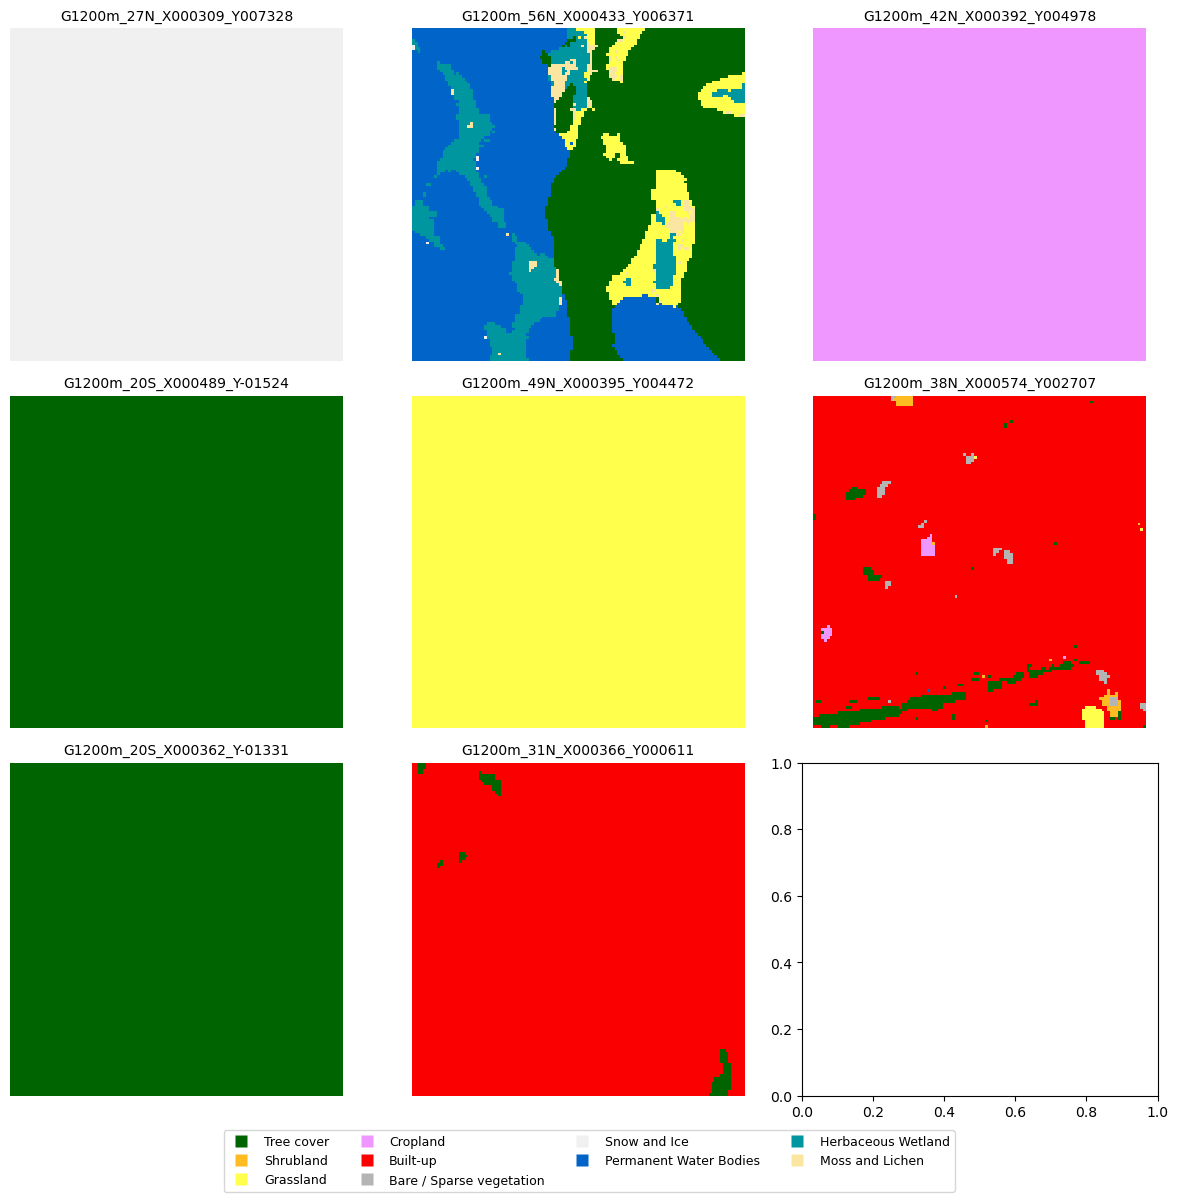

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Visualise random ESA WorldCover tiles that were stored as zlib-compressed
byte arrays in the `esa_lc` column (one 120 × 120 uint8 tile per row).

Usage (inside a notebook):
    from plot_random_esa_tiles import show_random_tiles
    show_random_tiles(df_zone, n_tiles=4, seed=0)
"""

import random
import zlib
from typing import Tuple, List

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd


# ---------------------------------------------------------------------
# ESA WorldCover class → colour  (official v200 palette)
_WC_COLOURS = {
    10: ("Tree cover",                "#006400"),
    20: ("Shrubland",                 "#FFBB22"),
    30: ("Grassland",                 "#FFFF4C"),
    40: ("Cropland",                  "#F096FF"),
    50: ("Built-up",                  "#FA0000"),
    60: ("Bare / Sparse vegetation",  "#B4B4B4"),
    70: ("Snow and Ice",              "#F0F0F0"),
    80: ("Permanent Water Bodies",    "#0064C8"),
    90: ("Herbaceous Wetland",        "#0096A0"),
    95: ("Mangroves",                 "#00CF75"),
    100: ("Moss and Lichen",          "#FAE6A0"),
}
_sorted_codes: List[int] = sorted(_WC_COLOURS)

_PALETTE = [_WC_COLOURS[c][1] for c in _sorted_codes]
_CMAP = mcolors.ListedColormap(_PALETTE, name="ESA_WorldCover")
_NORM = mcolors.BoundaryNorm(_sorted_codes + [110], len(_PALETTE))


# ---------------------------------------------------------------------
def _decompress_tile(buf: bytes, shape: Tuple[int, int] = (120, 120),
                     dtype: np.dtype = np.uint8) -> np.ndarray:
    """Decompress zlib-compressed bytes back to a 2-D numpy array."""
    arr = np.frombuffer(zlib.decompress(buf), dtype=dtype)
    return arr.reshape(shape)


def show_random_tiles(df: pd.DataFrame, *,
                      n_tiles: int = 4, seed: int | None = None) -> None:
    """
    Plot ``n_tiles`` randomly chosen tiles from ``df``.
    Requires columns: ['tile_id', 'esa_lc'].
    """
    if seed is not None:
        random.seed(seed)

    # filter rows that actually contain data
    data_rows = df[df["esa_lc"].apply(lambda x: isinstance(x, (bytes, bytearray)) and len(x) > 0)]
    if len(data_rows) == 0:
        raise ValueError("No rows with non-empty 'esa_lc' found.")

    sample = data_rows.sample(n=min(n_tiles, len(data_rows)), random_state=seed)

    n_cols = int(np.ceil(np.sqrt(len(sample))))
    n_rows = int(np.ceil(len(sample) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 4 * n_rows),
                             squeeze=False)

    for ax, (_, row) in zip(axes.ravel(), sample.iterrows()):
        tile_arr = _decompress_tile(row["esa_lc"])
        ax.imshow(tile_arr, cmap=_CMAP, norm=_NORM, interpolation="nearest")
        ax.set_title(row["tile_id"], fontsize=10)
        ax.axis("off")

    # build a legend only for classes present in the sample
    present_codes = sorted(set(np.concatenate(
        [_decompress_tile(b).ravel() for b in sample["esa_lc"]]
    )))
    handles = [plt.Line2D([0], [0], marker='s', linestyle='',
                          markersize=8, markerfacecolor=_WC_COLOURS[c][1],
                          markeredgecolor='none', label=_WC_COLOURS[c][0])
               for c in present_codes if c in _WC_COLOURS]

    fig.legend(handles=handles, loc="lower center",
               ncol=min(len(handles), 4), fontsize=9)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()



# import argparse, pathlib, pyarrow.parquet as pq
parquet_file = r"D:\NestEO_test_outputs\esa_lc_tiles_1200m\1200m/esa_lc_selected.parquet"
# Load lazily with PyArrow then to pandas (only needed columns)
df_tiles = pd.read_parquet(parquet_file, columns=["tile_id", "esa_lc"])
# df_tiles = table.to_pandas()

show_random_tiles(df_tiles, n_tiles=8, seed=42)


## Run For the entire grid of 1200m in projected system

In [338]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Batch-extract 120 × 120 ESA WorldCover arrays for each 1 200 m NestEO grid cell
stored in *multiple* zone-specific Parquet files.

Output: one Parquet per zone with columns
    ─ tile_id : str
    ─ esa_lc  : zstd-compressed uint8[120×120] bytes

Dependencies: geopandas ≥0.14, rasterio ≥1.3, GDAL ≥3.6, dask ≥2024, pyarrow ≥15
"""

# ───────────────────────── USER SETTINGS ─────────────────────────
GRID_FOLDER        = r"D:/nesteo_hf/grids/grids_full/grid_1200m"     # 122 Parquets
RASTER_DIR         = r"F:/ESA_LC_Raw"                     # ≈1 922 GeoTIFF tiles
RASTER_OUTLINE_SHP = r"F:/ESA_LC_Raw/raster_outlines.shp" # must contain 'raster_fil'
OUTPUT_ROOT        = r"D:/NestEO/esa_lc_grid_1200m"     # one Parquet per zone
RESOLUTION_M       = 10           # 10 m ⇒ 120 × 120 px
PARTITION_SIZE     = 10000        # polygons per spatial K-means cluster
N_WORKERS          = 10
MEM_LIMIT          = "4GB"        # per worker
OMP_THREADS        = 1
# ─────────────────────────────────────────────────────────────────

import os, sys, zlib, gc, json, tempfile, warnings, dask
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkt
from dask import delayed
from dask.distributed import Client, LocalCluster
from sklearn.cluster import KMeans
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.features import geometry_mask
from rasterio import warp
from osgeo import gdal

# ensure single-threaded raster ops
os.environ["OMP_NUM_THREADS"] = str(OMP_THREADS)
warnings.filterwarnings("ignore", category=UserWarning, module="geopandas")

# ───────────────────── helper utilities ─────────────────────
def _compress(arr: np.ndarray, lvl: int = 3) -> bytes:
    """zstd-compress a uint8 array."""
    return zlib.compress(arr.tobytes(), level=lvl)

def _kmeans_parts(gdf: gpd.GeoDataFrame, max_sz: int):
    n_cls  = max(1, len(gdf) // max_sz)
    cent   = np.column_stack([gdf.geometry.centroid.x,
                              gdf.geometry.centroid.y])
    labels = KMeans(n_clusters=n_cls, n_init="auto",
                    random_state=42).fit(cent).labels_
    gdf = gdf.copy(); gdf["_c"] = labels
    return [gdf[gdf._c == k].drop(columns="_c") for k in range(n_cls)]

# ─────────────── partition-level extraction ────────────────
@delayed
def _process_part(part_gdf: gpd.GeoDataFrame,
                  raster_dir: str,
                  outline_gdf: gpd.GeoDataFrame,
                  dst_crs: str,
                  res_m: float):
    if part_gdf.empty:
        return pd.DataFrame(columns=["tile_id", "esa_lc"])

    # warp grid covering the partition
    minx, miny, maxx, maxy = part_gdf.total_bounds
    width  = int(round((maxx - minx) / res_m))
    height = int(round((maxy - miny) / res_m))
    dst_tr = rasterio.Affine(res_m, 0, minx, 0, -res_m, maxy)
    src_bounds = warp.transform_bounds(dst_crs, "EPSG:4326",
                                       minx, miny, maxx, maxy)

    # intersecting GeoTIFFs
    sel = outline_gdf.cx[src_bounds[0]:src_bounds[2],
                         src_bounds[1]:src_bounds[3]]
    tif_paths = [Path(raster_dir) / fn for fn in sel.raster_fil.unique()
                 if (Path(raster_dir) / fn).exists()]
    if not tif_paths:
        return pd.DataFrame({"tile_id": part_gdf.tile_id.values,
                             "esa_lc": [b''] * len(part_gdf)})

    # temporary VRT
    with tempfile.NamedTemporaryFile(suffix=".vrt", delete=False) as tmp:
        vrt_path = tmp.name
    gdal.BuildVRT(vrt_path, list(map(str, tif_paths)))

    rows = []
    with rasterio.open(vrt_path) as src:
        vrt_opts = dict(crs=dst_crs, transform=dst_tr,
                        width=width, height=height,
                        resampling=Resampling.nearest,
                        src_bounds=src_bounds,
                        src_nodata=0, count=1,
                        blockxsize=512, blockysize=512)
        with WarpedVRT(src, **vrt_opts) as vrt:
            for _, row in part_gdf.iterrows():
                poly, tid = row.geometry, row.tile_id
                win  = from_bounds(*poly.bounds, transform=dst_tr)
                data = vrt.read(1, window=win)
                mask = geometry_mask([poly.__geo_interface__],
                                     transform=vrt.window_transform(win),
                                     invert=True, out_shape=data.shape)
                data[~mask] = 1   # outside polygon
                rows.append({"tile_id": tid,
                             "esa_lc": _compress(data.astype("uint8"))})
    os.remove(vrt_path)
    return pd.DataFrame(rows)

# ──────────────── zone-level Dask routine ────────────────
def _run_zone(zone_gdf, raster_dir, outline, res_m,
              part_sz, n_workers, mem_lim):
    crs   = zone_gdf.crs
    parts = _kmeans_parts(zone_gdf, part_sz)

    dask.config.set({"distributed.worker.memory.target": 0.97,
                     "distributed.worker.memory.spill":  0.97,
                     "distributed.worker.memory.pause":  0.97})
    cluster = LocalCluster(n_workers=n_workers,
                           threads_per_worker=1,
                           memory_limit=mem_lim,
                           dashboard_address=":0")
    client  = Client(cluster)
    print("Dask dashboard:", client.dashboard_link)

    try:
        tasks  = [_process_part(p, raster_dir, outline, crs, res_m)
                  for p in parts]
        frames = dask.compute(*tasks, scheduler="distributed")
        frames = [f for f in frames if not f.empty]
        df     = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    finally:
        client.close(); cluster.close(); gc.collect()
    return df

# ─────────────────────────── main ───────────────────────────
def main():
    Path(OUTPUT_ROOT).mkdir(parents=True, exist_ok=True)
    outline = gpd.read_file(RASTER_OUTLINE_SHP).to_crs("EPSG:4326")

    grid_files = sorted(Path(GRID_FOLDER).glob("*.parquet"))
    if not grid_files:
        sys.exit(f"No Parquet files found in {GRID_FOLDER}")

    for pf in grid_files:
        zone_name = pf.stem                           # e.g. grid_1200m_11N
        out_path  = Path(OUTPUT_ROOT) / f"{zone_name}.parquet"
        if out_path.exists():
            print(f"✓ {zone_name} already processed.")
            continue

        zone_gdf = gpd.read_parquet(pf)
        if zone_gdf.empty:
            print(f"× {zone_name} is empty ‒ skipped.")
            continue
        epsg = zone_gdf.crs.to_epsg() or "unknown"
        print(f"\n── Processing {zone_name} (EPSG:{epsg}, {len(zone_gdf)} tiles)")

        # ensure only required columns present
        zone_gdf = zone_gdf[["tile_id", "geometry"]]

        df_zone = _run_zone(zone_gdf, RASTER_DIR, outline,
                            RESOLUTION_M, PARTITION_SIZE,
                            N_WORKERS, MEM_LIMIT)

        if df_zone.empty:
            print(f"× No valid tiles for {zone_name}.")
            continue

        df_zone.to_parquet(
            out_path,
            engine="pyarrow",
            compression="zstd",
            use_dictionary=True,
            data_page_size=2 * 1024 * 1024,
            row_group_size=50_000,
            flavor="spark",
            version="2.6",
            index=False,
        )
        print("Saved →", out_path)

if __name__ == "__main__":
    main()



── Processing grid_10N_1200 (EPSG:32610, 2936912 tiles)
Dask dashboard: http://127.0.0.1:51533/status


2025-05-23 02:50:47,909 - distributed.protocol.pickle - ERROR - Failed to serialize <ToPickle: HighLevelGraph with 293 layers.
 0. _process_part-1390fd32-c8ef-417a-bdc5-010b4ef93d74
 1. _process_part-d371243d-42f4-4f3e-bcdd-509bde08db35
 2. _process_part-bbae1337-37e5-4c70-91be-fdd62c549388
 3. _process_part-d1997260-9138-4a8d-b3d5-7d0440104a73
 4. _process_part-c246c8a0-595a-40d5-b39e-a2018464586c
 5. _process_part-a6fcb46b-f9a0-4a59-b0b5-0490ff3a1e5d
 6. _process_part-4063dbba-0824-4836-a89c-a33ceba77c40
 7. _process_part-b15cb706-3d2a-4b83-ab11-c83c83751c54
 8. _process_part-2cdd0930-889d-449e-8525-8bea052fa03c
 9. _process_part-d335b4e6-3c13-4ed1-b666-918f0d35309b
 10. _process_part-3a8e9348-9070-49fb-ac39-344d48524ac3
 11. _process_part-096fefce-e9be-4fd3-bfa6-b59404cf60e7
 12. _process_part-1f77cccf-9dba-435f-be02-8a21de50b9bd
 13. _process_part-be77efeb-9dda-4563-9f97-3746ff7c3028
 14. _process_part-794a5d8f-54c5-4992-ad3b-80d988a0c06d
 15. _process_part-e0eff8a6-2366-4906-a3bc-

TypeError: ('Could not serialize object of type HighLevelGraph', '<ToPickle: HighLevelGraph with 293 layers.\n<dask.highlevelgraph.HighLevelGraph object at 0x1da7d8719d0>\n 0. _process_part-1390fd32-c8ef-417a-bdc5-010b4ef93d74\n 1. _process_part-d371243d-42f4-4f3e-bcdd-509bde08db35\n 2. _process_part-bbae1337-37e5-4c70-91be-fdd62c549388\n 3. _process_part-d1997260-9138-4a8d-b3d5-7d0440104a73\n 4. _process_part-c246c8a0-595a-40d5-b39e-a2018464586c\n 5. _process_part-a6fcb46b-f9a0-4a59-b0b5-0490ff3a1e5d\n 6. _process_part-4063dbba-0824-4836-a89c-a33ceba77c40\n 7. _process_part-b15cb706-3d2a-4b83-ab11-c83c83751c54\n 8. _process_part-2cdd0930-889d-449e-8525-8bea052fa03c\n 9. _process_part-d335b4e6-3c13-4ed1-b666-918f0d35309b\n 10. _process_part-3a8e9348-9070-49fb-ac39-344d48524ac3\n 11. _process_part-096fefce-e9be-4fd3-bfa6-b59404cf60e7\n 12. _process_part-1f77cccf-9dba-435f-be02-8a21de50b9bd\n 13. _process_part-be77efeb-9dda-4563-9f97-3746ff7c3028\n 14. _process_part-794a5d8f-54c5-4992-ad3b-80d988a0c06d\n 15. _process_part-e0eff8a6-2366-4906-a3bc-6793c1f25980\n 16. _process_part-1448538f-da28-4480-8c99-aa417ad05ce9\n 17. _process_part-8af458c4-8451-4c9b-9eb6-a19679fdeea3\n 18. _process_part-e36f1e54-ee76-4534-9777-5fa0f317b69f\n 19. _process_part-a8773575-0ad6-4c6c-bc6c-22fbe4ed3024\n 20. _process_part-5cf4c984-556f-4d75-b3bb-26ce6b80f6aa\n 21. _process_part-0674e90e-0d47-4d77-aadd-48a83baecbbd\n 22. _process_part-022b2b0b-6525-4ce2-8b42-732efe28be0a\n 23. _process_part-12020ff3-6a06-4aa5-a052-69011b959d83\n 24. _process_part-2d8d853e-a5ea-45a0-bc51-299ef796f9cf\n 25. _process_part-8ee0f7e9-153a-41d7-b0d0-e9197bb12c13\n 26. _process_part-208524f9-99db-4ee8-a28f-35890eca2b37\n 27. _process_part-5adbf836-de99-46ed-ae38-b6c43ad36963\n 28. _process_part-3a533320-0a43-40c5-b6eb-1b3452a0b4d4\n 29. _process_part-7cc1c752-d1d8-49a9-b903-189f089c2b63\n 30. _process_part-d5afbe2f-f8f5-4a3d-8375-bb9f7171b57e\n 31. _process_part-1edea960-5902-484f-b543-36a2d951a0b3\n 32. _process_part-0633300f-8f39-447c-a2e0-e60037ae2969\n 33. _process_part-97844d9d-a960-4e30-9d29-6d0e83014444\n 34. _process_part-126ed16b-749d-4621-9450-a979c5df9791\n 35. _process_part-72498018-62d4-493d-a6d3-3fbaf25be59b\n 36. _process_part-9364266f-d289-48fd-9a18-cf281b11911d\n 37. _process_part-a921cee6-a535-43e5-aa31-f31c343d88bd\n 38. _process_part-bc036b85-ad27-4fa5-9797-c030ff1954bd\n 39. _process_part-c98f5846-e048-4f58-86ae-a42917e092c8\n 40. _process_part-52a66b37-4fbc-4a8b-99ef-1e0a66c170e6\n 41. _process_part-0def8cf5-b1e3-40e3-8cc9-496c82ec2ab1\n 42. _process_part-5d6cadd3-f56e-4517-98ff-e5d6728f508d\n 43. _process_part-261dc145-e430-4142-800e-85d05cac3911\n 44. _process_part-6135a357-f7eb-454d-b702-521507f35ddc\n 45. _process_part-dbec712b-cad9-43de-b3d6-29b4a72e0b34\n 46. _process_part-70e4eba9-14e7-4b87-92b8-291671ac9892\n 47. _process_part-73f879f7-4e3e-432f-b28e-42a04c28bcbd\n 48. _process_part-8c1a870f-829e-4b33-bb81-78efdd2669aa\n 49. _process_part-391c22b2-593a-4c6b-8c02-436351215bb0\n 50. _process_part-a27348d8-ce34-4090-9f6e-7c5a669b6271\n 51. _process_part-572b70d4-e35c-4ced-82de-147f94449c4c\n 52. _process_part-cc760c52-6c1f-4560-bc81-15f462b9a65f\n 53. _process_part-4953b5bf-707b-417b-89d1-00e0bd7c22e4\n 54. _process_part-71a3de7a-1a6a-4c34-9354-671d9596c11b\n 55. _process_part-3226348e-dae6-44c9-bd64-352c543025a8\n 56. _process_part-edfa9095-f82f-48f5-8e9d-3f5bf88def1e\n 57. _process_part-a7b1a0f0-927e-4088-aae6-bafc0b36c6b8\n 58. _process_part-e8f2f391-02c0-40d6-9be6-083898e989a1\n 59. _process_part-866dd267-abde-4690-88e7-0538a392e91d\n 60. _process_part-d25a393a-455b-4c4b-92b2-6fa7b9fbdaec\n 61. _process_part-8f4e5112-c733-461d-981e-20472c2317a1\n 62. _process_part-1531713a-a58d-4f0d-b5ab-feace7ca57df\n 63. _process_part-333ec001-dbd8-4579-b283-9e3b9059130a\n 64. _process_part-1dd16b1f-ae3d-4dda-b56b-78bc5acdc01b\n 65. _process_part-f8a3c7ba-594d-4b2b-898b-78556552f7d3\n 66. _process_part-86dda6d0-a191-4223-910b-09ef91e5a47f\n 67. _process_part-d73eddb2-5830-4aac-b0f1-2f983b086c65\n 68. _process_part-8fa39c71-8cc9-48d2-b5c5-0163929bc7c0\n 69. _process_part-993ecb5d-c9db-4666-a2dc-707ea1f1d05c\n 70. _process_part-20ed8e9f-6b51-4a10-92f4-bc62f159804a\n 71. _process_part-0b1fd0ac-982a-4900-becf-2abb76fccac4\n 72. _process_part-e2f014af-84db-46ce-8d5b-60603cc7e792\n 73. _process_part-0334518e-c367-427f-8343-2e4b9a24b1ed\n 74. _process_part-81598bd5-8bbc-4718-b5af-c2a75fb9ec9a\n 75. _process_part-f2b19104-1986-4f92-b4f8-4bb7cdadb84c\n 76. _process_part-aaf55dfb-a7ef-42a5-9a6f-8c2f8542de8c\n 77. _process_part-98971258-edbb-4ef9-a5a7-fa4bc4b9168b\n 78. _process_part-d0c1a1ea-406a-4ef4-9de4-282183829239\n 79. _process_part-1dd6992d-587a-4fb1-8f76-976d6960525d\n 80. _process_part-ee5b5ac7-8f49-4477-b506-2e13495cc66a\n 81. _process_part-fadae182-c2dc-403f-b403-dc8cf2f5994b\n 82. _process_part-2e4f23b0-3234-4e85-a587-7f1abc80dc0d\n 83. _process_part-b0cbb35f-08f1-4c12-97be-8b6cb4c28a17\n 84. _process_part-b849b30b-668b-42d9-bedd-0820aede51b7\n 85. _process_part-97063e76-f6a8-4834-b2e7-02f942ed9981\n 86. _process_part-1e93ae14-ca3b-4951-b156-c47bd6e003c4\n 87. _process_part-8cf38bc9-ca5c-489a-a3ec-5cbfb754a2ee\n 88. _process_part-dc90df05-3652-44f2-b28e-388729b52a5b\n 89. _process_part-43293f10-9d96-4451-a9e3-832a2aa483a0\n 90. _process_part-be1047f0-36c4-428e-afcb-103c0fc515b9\n 91. _process_part-bdfa1eb1-81f2-42d1-93ac-23ae33785ee3\n 92. _process_part-dd40d916-9cdb-44e3-bdcd-68f4b390d05b\n 93. _process_part-0f6f2706-27cc-42fd-8a78-0c0294184074\n 94. _process_part-df77a5c3-96f5-4749-8b52-f0845f3553ba\n 95. _process_part-8b2c6e4b-cb1f-438a-bdfb-b88d244a3a56\n 96. _process_part-c61d6182-c370-4f16-a554-f37e978608f1\n 97. _process_part-cf71bc10-5ef4-4025-881e-6dafd9bf597a\n 98. _process_part-a1bed795-c42d-4b12-b33b-b6f546b201e2\n 99. _process_part-94c77e9b-cb66-4ee5-b1c6-704a1a231ae4\n 100. _process_part-babd09d5-89a5-4f37-902b-bf369622322c\n 101. _process_part-c3a49d27-ca20-46a7-b3c4-d324f7f6cd25\n 102. _process_part-de951fa8-fc49-4c10-abeb-79d7d5344afb\n 103. _process_part-f67a852b-5352-47b9-ae76-394afd7c4da6\n 104. _process_part-f3958b47-402f-46f2-b7a7-9ad7df52466c\n 105. _process_part-063cd622-f1b8-4972-a0dc-582ea8186552\n 106. _process_part-8c893a18-95d8-4ec8-b6bc-f8dedcdc9500\n 107. _process_part-c0e508f5-9cd6-4420-bef0-178b462ed2e9\n 108. _process_part-d4acebe5-56c0-4315-aea6-c1534fd71d94\n 109. _process_part-f1fef256-6d35-4140-ba1e-95fd9634bf29\n 110. _process_part-bcc28756-5950-4597-b479-56eb4fd018c5\n 111. _process_part-9e69344a-3988-4fdb-ba02-f8c6d65b58cc\n 112. _process_part-d4dc4828-5ffa-458f-9a6e-6169d4399e93\n 113. _process_part-9ae5206c-14eb-47c4-b812-e46809a8c119\n 114. _process_part-7e762a25-4d1e-4682-9170-75ee68febb40\n 115. _process_part-482673ce-a3f7-4bea-974a-e8bb6db24a6b\n 116. _process_part-8eb30c19-0da4-452f-b214-1f9440d5a226\n 117. _process_part-e3488da3-0601-460c-94a3-aa1a69ce92a6\n 118. _process_part-bd584b36-2837-4f03-ba14-14a6fe50009c\n 119. _process_part-2fdabd60-5dfb-4a3d-858d-c1a98d2f85fb\n 120. _process_part-d7d8f2a0-e694-40bf-928d-b7e8c609d9d1\n 121. _process_part-b93f258e-4315-49c7-ba82-ce838ed889ac\n 122. _process_part-49b8802a-9037-4262-bb80-bb8575192bfc\n 123. _process_part-e722dac0-74b5-4eae-843c-7f4d8c81709a\n 124. _process_part-af9f3a27-d8cc-4bab-8963-ab0fd5956c68\n 125. _process_part-7fac7643-fe91-4e1e-82dc-46cd26892c3e\n 126. _process_part-77fe9ca3-831e-4850-b444-543244a7ce23\n 127. _process_part-bb47b73e-3e6f-459c-a83d-6b0bc74b8b0c\n 128. _process_part-308eafe1-d902-4e93-96f3-b5bb6f992bfb\n 129. _process_part-aecb551b-e764-445b-b72b-9013712e5e8b\n 130. _process_part-83bee495-f40f-434a-a3aa-85d86f86c540\n 131. _process_part-295ba62f-fefe-4e3c-89dd-6a53339aa968\n 132. _process_part-5cdd19d5-c1c2-4ee7-a35a-84f9e446f766\n 133. _process_part-4694e435-6aae-4cb5-9a14-14dd062ad46f\n 134. _process_part-8c1d07e6-244d-4c73-b307-139f714a52d8\n 135. _process_part-5d8aa616-16a6-4ab1-84d8-046aa649310e\n 136. _process_part-547bc18f-cf65-431d-82ee-a7f3e34907f5\n 137. _process_part-c9bc4909-f394-4056-8992-44ea3ac7395e\n 138. _process_part-1bfd8b7c-0b30-4e8f-9fcc-3fd0cfff435b\n 139. _process_part-2459b835-5ebb-4f80-8a35-97b40985cd55\n 140. _process_part-c158850b-8b9b-4ec0-8c79-63e6b7f4ff65\n 141. _process_part-41ee3a16-b339-480b-81aa-7a6d865a2b70\n 142. _process_part-807806a7-5927-4403-bd33-179b9575da00\n 143. _process_part-d9893631-44c1-4427-94b7-58453b6ba012\n 144. _process_part-65ed5b24-6858-4e10-ad57-e6f62fc889cb\n 145. _process_part-59664cd8-da65-4eaf-8661-7fc73c887bd9\n 146. _process_part-6539c846-769e-416a-aca5-3401fc09c5da\n 147. _process_part-95a943bc-c0b2-461d-b0fa-a3547e2a185f\n 148. _process_part-e182b8b5-cd84-49e9-a5f7-215c00788952\n 149. _process_part-848eb44c-081c-4fdb-a225-e6b661b9c373\n 150. _process_part-de6607f1-ebb2-4ceb-94a0-b199995b1cc2\n 151. _process_part-20cdf9e8-aeac-4ff8-bb67-f5830b67a597\n 152. _process_part-e8f7dc6e-e673-47d4-858d-c0c8baede47f\n 153. _process_part-001ed1ce-2d8d-42a0-ab7d-0b01cfd5522c\n 154. _process_part-83dc83de-feb0-491f-a4c9-93df65cc1380\n 155. _process_part-5f523bc1-4e4a-4453-828b-e64bd258dd65\n 156. _process_part-fd02ccdd-ef00-45ad-9bdd-e5d6f94b4580\n 157. _process_part-35e55a37-313c-4457-bcea-fe276c8c74de\n 158. _process_part-17156f6e-edc0-43fc-98a6-8895640b69f4\n 159. _process_part-06c17d49-27fe-4c56-a36c-38b4a86f9e8f\n 160. _process_part-3c62899d-c2cf-4820-af47-168c98408bd9\n 161. _process_part-0b8503fd-e984-4c81-8fd3-db3bef55baf8\n 162. _process_part-e6d30c1b-12ae-480d-98fa-3bfef7d8c3bf\n 163. _process_part-cb98b95e-c9b1-4238-90c7-fe4bb1162d0f\n 164. _process_part-35f0fd24-dc76-4ddb-8c5d-7247cc79af89\n 165. _process_part-515348f9-6638-4688-a07c-5aaee0300a78\n 166. _process_part-a5aceb9f-99b5-431e-9276-9fca3ed6ee28\n 167. _process_part-7bfd239b-3d42-445a-ab00-97ce54de37a3\n 168. _process_part-7b6d7008-29ca-4231-9b9a-fddb528c1411\n 169. _process_part-8a35fd41-997e-4859-95cb-3fe69b545896\n 170. _process_part-3cb8ffee-2646-44d1-ba77-13dd827a7fc8\n 171. _process_part-49a822ec-eb59-4418-9362-c9ca3cce665d\n 172. _process_part-78319962-e5e1-427c-84ed-221ddde3eb9b\n 173. _process_part-34f034ab-7882-471e-983e-60c62f100da6\n 174. _process_part-538bfe0a-0d48-47d0-996d-290136931f4b\n 175. _process_part-d4612ee7-74')

In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa
from pathlib import Path
from tqdm import tqdm

# ─────────────── CONFIGURATION ───────────────
root_dir = Path("/path/to/your/grid_parquets")  # update this
output_path = Path("/path/to/your/grid_index.parquet")  # update this
target_columns = ['tile_id', 'super_id']

# ─────────────── COLLECT PARQUETS ───────────────
all_parquets = list(root_dir.rglob("*.parquet"))

# ─────────────── LOAD AND FILTER ───────────────
tables = []
for pfile in tqdm(all_parquets, desc="Reading parquet files"):
    try:
        pq_file = pq.ParquetFile(pfile)
        available_cols = pq_file.schema.names
        if all(col in available_cols for col in target_columns):
            table = pq_file.read(columns=target_columns)
            tables.append(table)
    except Exception as e:
        print(f"Skipping {pfile.name} due to error: {e}")

# ─────────────── CONCATENATE ───────────────
if not tables:
    raise RuntimeError("No valid Parquet files with both 'tile_id' and 'super_id' found.")

final_table = pa.concat_tables(tables)

# ─────────────── DETERMINE ROW GROUP SIZE ───────────────
total_rows = final_table.num_rows
row_group_size = max(1, total_rows // 512)

# ─────────────── WRITE OUTPUT ───────────────
pq.write_table(
    final_table,
    output_path,
    row_group_size=row_group_size,
    compression='zstd'
)

print(f"grid_index.parquet written to {output_path} with {total_rows} rows in ~512 row groups.")


In [7]:
import os

def search_in_files(root_dir, search_text, file_extensions=None):
    """
    Recursively search for a string inside files in a directory.
    
    Args:
        root_dir (str): The root directory to start searching.
        search_text (str): The text to search within files.
        file_extensions (list or None): If provided, only files with these extensions will be searched.
    """
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if file_extensions and not any(filename.endswith(ext) for ext in file_extensions):
                continue
            file_path = os.path.join(dirpath, filename)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    for i, line in enumerate(f, start=1):
                        if search_text in line:
                            print(f"[MATCH] {file_path} (Line {i}): {line.strip()}")
            except Exception as e:
                print(f"[ERROR] Cannot read {file_path}: {e}")

# Example usage
if __name__ == "__main__":
    search_root = "D:/NestEO"
    text_to_find = "henarcmeo"
    extensions = []  # Set to None to search all file types
    search_in_files(search_root, text_to_find, extensions)


[MATCH] D:/NestEO\.git\index (Line 25): *h~K                    G(yt40+ )scripts/create_henarcmeo_repo_scaffold.py h
[MATCH] D:/NestEO\.git\index (Line 32):  Vhe-                      zm-,$? src/henarcmeo/__init__.py h
[MATCH] D:/NestEO\.git\index (Line 34): lA% 'src/henarcmeo/aux_datasets/utils_aux.py   h
[MATCH] D:/NestEO\.git\index (Line 36): 1 7M                     yU3~P;9XI src/henarcmeo/core/__init__.py    h
[MATCH] D:/NestEO\.git\index (Line 39): 'xrCfs6R:.;t src/henarcmeo/core/main.py        h
[MATCH] D:/NestEO\.git\index (Line 40): -	Ph`                    ## "d[{4h8@3| src/henarcmeo/core/structure.py   h
[MATCH] D:/NestEO\.git\index (Line 42): 1                     HXAАQx:ѯQ src/henarcmeo/grid/__init__.py    h
[MATCH] D:/NestEO\.git\index (Line 43): wHh!4x                   .ᦀ.W=IgE $src/henarcmeo/grid/grid_generator.py      h
[MATCH] D:/NestEO\.git\index (Line 45): z                      }kn<fad src/henarcmeo/utils/utils.py      TREE  x 

In [ ]:
import pandas as pd
aa = pd.read_parquet("D:/NestEO_test_outputs/grid_600m\lc_proportions_10m_56S_600m.parquet")
aa.head()

In [ ]:
import pandas as pd
from collections import defaultdict
import json

def average_landcover_props(df: pd.DataFrame, super_col: str = 'super_id') -> pd.DataFrame:
    """
    Averages landcover proportions grouped by super_id.
    
    Parameters:
        df: DataFrame with 'landcover_props' (dict), and 'super_id'
        super_col: Column indicating the grouping parent (super tile)
    
    Returns:
        New DataFrame with averaged landcover proportions per super tile.
    """
    grouped_props = defaultdict(lambda: defaultdict(float))
    counts = defaultdict(int)

    for _, row in df.iterrows():
        super_id = row[super_col]
        lc_dict = row['landcover_props']
        for cls, val in lc_dict.items():
            grouped_props[super_id][cls] += val
        counts[super_id] += 1

    # Normalize
    averaged = []
    for super_id, class_totals in grouped_props.items():
        count = counts[super_id]
        avg_props = {cls: round(val / count, 6) for cls, val in class_totals.items()}
        averaged.append({
            'tile_id': super_id,  # now tile_id represents super tile
            'landcover_props': avg_props
        })

    return pd.DataFrame(averaged)


In [ ]:
# Example input dataframe
df = pd.DataFrame({
    'tile_id': [
        'G600m_56S_X000338_Y-04948',
        'G600m_56S_X000339_Y-04948',
        'G600m_56S_X000333_Y-04947',
        'G600m_56S_X000334_Y-04947',
        'G600m_56S_X000335_Y-04947'
    ],
    'landcover_props': [
        {40: 0.87056, 60: 0.00306, 30: 0.02361, 10: 0.10278},
        {40: 0.92083, 30: 0.04722, 60: 0.00694, 10: 0.025},
        {10: 0.35694, 30: 0.29444, 40: 0.34861},
        {30: 0.01028, 40: 0.98972},
        {40: 1.0}
    ],
    'super_id': [
        'G1200m_56S_X000169_Y-02474',
        'G1200m_56S_X000169_Y-02474',
        'G1200m_56S_X000166_Y-02473',
        'G1200m_56S_X000166_Y-02473',
        'G1200m_56S_X000166_Y-02473'
    ]
})

result_df = average_landcover_props(df)
print(result_df)


In [ ]:
# Entry-point for batch run
zones = [f"{i}{d}" for i in range(1, 61) for d in ["N", "S"]]
grid_size = 600
resolution = 10
n_workers = 8
process_mosaic = False
raster_dir = r"F:/ESA_LC_Raw"

# part_sizes = {120000: 30, 12000: 1000, 6000: 5000, 1200: 20000, 600: 50000, 300: 100000}
# partition_size = part_sizes[grid_size]


default_levels = [300, 600, 1200, 6000, 12000, 120000]
i = default_levels.index(grid_size)
if (i+1) < len(default_levels):
    super_grid_size = default_levels[i + 1]
else:
    super_grid_size=None
print("super_grid_size: ", super_grid_size)

grid_dir = f"D:/NestEO_test_outputs/grid_{grid_size}m"
super_dir = f"D:/NestEO_test_outputs/grid_{super_grid_size}m"


for zone in zones:
    if zone in ["1N", "1S", "60N", "60S"]:
        continue
    # if "N" in zone:
    #     continue
    st = time()
    out_file = os.path.join(grid_dir, f"lc_proportions_{resolution}m_{zone}_{grid_size}m.parquet")
    print(out_file)

    if os.path.exists(out_file):
        print("\nSkipping, file exists: ", out_file)
        continue

    if process_mosaic:
        raster_path = os.path.join(raster_dir, f"ESA_LC_UTM_zone_{zone}_grid.tif")
        raster_outline_gdf = None
    else:
        raster_path = raster_dir
        raster_outline_gdf = gpd.read_file("F:/ESA_LC_Raw/raster_outlines.shp")
        print("\nTotal tiles: ", len(raster_outline_gdf))

    if not os.path.exists(raster_path):
        print("\nNOT FOUND: ", raster_path)
        continue
    print("\nProcessing zone:", zone)
    parquet_file = os.path.join(grid_dir, f"grid_{zone}_{grid_size}.parquet")
    if os.path.exists(parquet_file):
        gdf = gpd.read_parquet(parquet_file)[["tile_id", "super_id", "geometry"]].copy()
    else:
        raise ValueError(f"{parquet_file} grid file not found..")
    # Make use of the heirarchy and nesting    
    if super_grid_size:
        super_result_file = os.path.join(super_dir, f"lc_proportions_{resolution}m_{zone}_{super_grid_size}m.parquet")
        # print(super_result_file)
        if not os.path.exists(super_result_file):
            raise ValueError(f"Missing super-level results: {super_result_file}")
        super_df = pd.read_parquet(super_result_file)
        super_zero_tiles = set(
            super_df.loc[super_df["landcover_props"] == "{0: 1.0}", "tile_id"]
        )
    else:
        super_zero_tiles = set()


    if super_zero_tiles:
        zero_gdf = gdf[gdf["super_id"].isin(super_zero_tiles)].copy()
        non_zero_gdf = gdf[~gdf["super_id"].isin(super_zero_tiles)].copy()
    else:
        zero_gdf = gdf.iloc[0:0]  # Empty
        non_zero_gdf = gdf.copy()
    if zone in ["1N", "1S", "60N", "60S"]:
        # Area-based filtering useful for border zones
        max_area = 2 * grid_size * grid_size  # Dynamic threshold based on grid resolution (in meters)
        non_zero_gdf["area"] = non_zero_gdf.geometry.area
        oversized_gdf = non_zero_gdf[non_zero_gdf["area"] > max_area].copy()
        non_zero_gdf = non_zero_gdf[non_zero_gdf["area"] <= max_area].copy()
        print("Oversized excluded: ", len(oversized_gdf), "remaining: ", len(non_zero_gdf))
        # Assign placeholder landcover proportions to oversized polygons
        oversized_gdf["landcover_props"] = ["{-1: 1.0}"] * len(oversized_gdf)
        oversized_df = oversized_gdf[["tile_id", "landcover_props"]]
    else:
        oversized_df = pd.DataFrame(columns=["tile_id", "landcover_props"])
    total_cells = len(gdf)
    # gdf = gpd.read_parquet(parquet_file)[["tile_id", "super_id", "geometry"]].copy()
    total_cells = len(gdf)
    non_zero_cells = len(non_zero_gdf)
    print(f"The zero records: {len(zero_gdf)}, The non-zero records: {non_zero_cells}")
    print(f"Percent processing: {non_zero_cells/total_cells*100}%")

    del super_zero_tiles, super_df  # Clean up memory
    gc.collect()

    
    large_factor = round((1/np.sqrt(grid_size)*100)+1, 0)
#     # large_factor = round((np.sqrt(non_zero_cells)/100) + 1, 0)
#     if non_zero_cells > 50000 and non_zero_cells < 100000:


    # if non_zero_cells > 15000:
    #     large_factor = 1.5
    # else:
    #     large_factor = 1
    ##################################################################################################
    # partition_size = min(partition_size, len(non_zero_gdf))
    partition_factor = n_workers*4*large_factor
    partition_size = int(non_zero_cells//partition_factor)+1
    memory_limit = f"{45.0/n_workers}GB"
    print("partition_size: ", partition_size, "memory_limit: ", memory_limit)
    df = run_zone(zone, non_zero_gdf, raster_path, resolution=resolution, partition_size=partition_size, 
             max_pixels=1e12, raster_outline_gdf=raster_outline_gdf, n_workers=n_workers, memory_limit=memory_limit)


    #################################################################################################


    # df = run_zone(zone, non_zero_gdf, raster_file, resolution=resolution, partition_size=partition_size)

    zero_gdf["landcover_props"] = ["{0: 1.0}"] * len(zero_gdf)
    zero_df = zero_gdf[["tile_id", "landcover_props"]]  # keep only required columns

    # Final full DataFrame
    df = pd.concat([df, zero_df], ignore_index=True)
    df["landcover_props"] = df["landcover_props"].astype(str)
    df.to_parquet(out_file, index=False, compression='snappy')
    # df.to_csv(out_file, index=False)

    assert len(df["tile_id"].unique()) == len(gdf["tile_id"].unique()), "Mismatch in tile counts!"
    print(f"Processed zone: {zone} in {(time()-st)/60} mins at {strftime('%H:%M:%S', localtime())}")

    del gdf, df  # or any large objects
    gc.collect()


prop_files = glob.glob(f"{grid_dir}/lc_proportions_{resolution}m_*_{grid_size}m.parquet")
# print(prop_files)
df_all = [pd.read_parquet(df) for df in prop_files]
df_all = pd.concat(df_all, ignore_index=True)
df_all.to_parquet(os.path.join(grid_dir, f"lc_proportions_{resolution}m_allzones_{grid_size}m.parquet"), index=False)



In [ ]:
import pandas as pd

# Entry-point for batch run
zones = [f"{i}{d}" for i in range(1, 61) for d in ["N", "S"]]
grid_size = 600
resolution = 10
n_workers = 8
process_mosaic = False
raster_dir = r"F:/ESA_LC_Raw"

# part_sizes = {120000: 30, 12000: 1000, 6000: 5000, 1200: 20000, 600: 50000, 300: 100000}
# partition_size = part_sizes[grid_size]

default_levels = [300, 600, 1200, 6000, 12000, 120000]
i = default_levels.index(grid_size)
if (i+1) < len(default_levels):
    super_grid_size = default_levels[i + 1]
else:
    super_grid_size=None
print("super_grid_size: ", super_grid_size)

grid_dir = f"D:/NestEO_test_outputs/grid_{grid_size}m"
super_dir = f"D:/NestEO_test_outputs/grid_{super_grid_size}m"


prop_files = glob.glob(f"{grid_dir}/lc_proportions_{resolution}m_*_{grid_size}m.parquet")
# print(prop_files)
df_all = [pd.read_parquet(df) for df in prop_files]
df_all = pd.concat(df_all, ignore_index=True)
df_all.to_parquet(os.path.join(grid_dir, f"lc_proportions_{resolution}m_allzones_{grid_size}m.parquet"), index=False)

In [ ]:
# Copied from other cell to create landcover columns

In [ ]:
import dask.dataframe as dd
import ast
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from dask.diagnostics import ProgressBar
import os
import glob

# -----------------------------------------------------------------------------------
# Landcover Setup
# -----------------------------------------------------------------------------------
landcover_legend = {
    0: "Open Seas", 10: "Tree Cover", 20: "Shrubland", 30: "Grassland",
    40: "Cropland", 50: "Built-up", 60: "Bare/Sparse Vegetation", 70: "Snow and Ice",
    80: "Permanent Water Bodies", 90: "Herbaceous Wetland", 95: "Mangroves", 100: "Moss and Lichen"
}
lc_columns = list(landcover_legend.values())

# -----------------------------------------------------------------------------------
# Expansion Function
# -----------------------------------------------------------------------------------
def expand_landcover_props_fast(df_partition):
    parsed = df_partition['landcover_props'].apply(ast.literal_eval)

    for col in lc_columns:
        df_partition[col] = 0.0

    for code, col_name in landcover_legend.items():
        df_partition[col_name] = parsed.apply(lambda d: d.get(code, 0.0))

    df_partition = df_partition.drop(columns=["landcover_props"])

    final_columns = ["tile_id"] + lc_columns
    df_partition = df_partition[final_columns]

    return df_partition

# -----------------------------------------------------------------------------------
# Paths
# -----------------------------------------------------------------------------------
input_folder_pattern = "D:/NestEO_test_outputs/grid_1200m/lc_proportions_10m_*_1200m.parquet"
output_folder = "D:/NestEO_test_outputs/grid_1200m/lc_props_with_columns/"

os.makedirs(output_folder, exist_ok=True)

# -----------------------------------------------------------------------------------
# Process Each Zone File Separately
# -----------------------------------------------------------------------------------
zone_files = sorted(glob.glob(input_folder_pattern))

print(f"Found {len(zone_files)} zone files to process.")

for file_path in zone_files:
    zone_name = os.path.basename(file_path).replace(".parquet", "")  # e.g., lc_proportions_10m_32N_1200m
    output_file = os.path.join(output_folder, f"{zone_name}.parquet")
    if os.path.exists(output_file):
        print(f"Skipping {zone_name}, already processed.")
        continue

    print(f"\nProcessing {zone_name}...")

    # Read the zone file lazily
    df = dd.read_parquet(
        file_path,
        engine="pyarrow",
        columns=["tile_id", "landcover_props"]
    )

    # Optional: repartition to larger partitions if needed
    df = df.repartition(partition_size="1GB")

    # Define correct meta
    meta_columns = {"tile_id": 'object'}
    meta_columns.update({col: 'float32' for col in lc_columns})

    # Expand
    df_expanded = df.map_partitions(expand_landcover_props_fast, meta=meta_columns)

    # Compute and Save
    with ProgressBar():
        df_final = df_expanded.compute()

    # Save cleanly
    table = pa.Table.from_pandas(df_final, preserve_index=False)
    pq.write_table(
        table,
        where=output_file,
        compression="snappy",
        use_dictionary=True,
        data_page_size=2097152,
        row_group_size=1000000
    )

    print(f"Saved expanded zone: {output_file}")

print("\nAll zones processed and saved successfully.")


## Converting lc stats into shapefile for confirmation

In [ ]:
import pandas as pd
import geopandas as gpd
# D:/NestEO_test_outputs/grid_120000m
p1 = pd.read_parquet("D:/NestEO_test_outputs/grid_120000m/lc_proportions_10m_3S_120000m.parquet")
grid = gpd.read_parquet("D:/NestEO_test_outputs/grid_120000m/grid_3S_120000.parquet")

In [ ]:
p1["landcover_props"] = p1["landcover_props"].astype(str)
p1_m = grid.merge(p1, on="tile_id")
p1_m = p1_m[["geometry", "tile_id", "landcover_props"]]
p1_m.to_file("D:/NestEO_test_outputs/grid_120000m/lc_proportions_10m_3S_120000m.shp")

In [ ]:
########################################################################################
########################################################################################
########################################################################################
########################################################################################

# ESA raster processings, mosaics and extra

In [ ]:
# Main code for compute
import os
from pathlib import Path
import rasterio
from shapely.geometry import box
import subprocess
from tqdm import tqdm

# === CONFIGURATION ===
input_dir = Path("F:/ESA_LC_Raw")  # Input ESA 10m tiles
output_dir = Path("F:/ESA_LC_UTM_Mosaics")  # Where UTM mosaics will be saved
gdalwarp_path = "gdalwarp"  # Assumes GDAL is in PATH or conda env already active
target_resolution = 100  # Change this to 50, 250, etc. as needed
overwrite = False  # Set to True to regenerate mosaics even if they exist

# === PREPARE OUTPUT DIR ===
output_dir.mkdir(parents=True, exist_ok=True)

# === UTM ZONE DEFINITION ===
def generate_utm_zones():
    zones = []
    for zone_number in range(1, 61):
        lon_min = (zone_number - 1) * 6 - 180
        lon_max = lon_min + 6
        zones.append({
            "zone": zone_number,
            "hemisphere": "N",
            "epsg": 32600 + zone_number,
            "lon_min": lon_min,
            "lon_max": lon_max,
            "lat_min": 0,
            "lat_max": 84
        })
        zones.append({
            "zone": zone_number,
            "hemisphere": "S",
            "epsg": 32700 + zone_number,
            "lon_min": lon_min,
            "lon_max": lon_max,
            "lat_min": -80,
            "lat_max": 0
        })
    return zones

# === LOAD ALL ESA TILES ===
esa_tiles = list(input_dir.glob("*.tif"))
print(f"Found {len(esa_tiles)} ESA tiles.")

# === BUILD ZONES ===
utm_zones = generate_utm_zones()

# === PROCESS EACH ZONE ===
for zone in tqdm(utm_zones, desc="Generating UTM Mosaics"):
    zone_name = f"UTM_{zone['zone']:02d}{zone['hemisphere']}"
    print(zone)
    output_tif = output_dir / f"{zone_name}_ESA_LC_{target_resolution}m.tif"
    if output_tif.exists() and not overwrite:
        continue

    zone_bounds = box(zone["lon_min"], zone["lat_min"], zone["lon_max"], zone["lat_max"])
    matching_tiles = []
    print("matching tiles... ")
    for tile in esa_tiles:
        try:
            with rasterio.open(tile) as src:
                tile_bounds = box(*src.bounds)
                if tile_bounds.intersects(zone_bounds):
                    matching_tiles.append(str(tile))
        except Exception:
            continue

    if not matching_tiles:
        continue  # No relevant tiles for this zone
    print(f"Total matching tiles: {len(matching_tiles)}")
    cmd = [
        gdalwarp_path,
        "-r", "mode",
        "-t_srs", f"EPSG:{zone['epsg']}",
        "-tr", str(target_resolution), str(target_resolution),
        "-tap",
        "-co", "COMPRESS=LZW",
        "-co", "BIGTIFF=YES",
        "-overwrite",
        *matching_tiles,
        str(output_tif)
    ]

    try:
        subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except subprocess.CalledProcessError as e:
        print(f"Failed: {zone_name} → {e}")
    break


In [ ]:
def create_mosaic_by_blocks_optimized(raster_paths, out_raster_path, clip_gdf=None):
    print(f"Creating mosaic for {len(raster_paths)} rasters...")

    if not raster_paths:
        return None

    if os.path.exists(out_raster_path):
        os.remove(out_raster_path)

    sources = [rio.open(rp) for rp in raster_paths]
    ref = sources[0]
    crs = ref.crs
    res = ref.res
    dtype = ref.dtypes[0]
    count = ref.count
    nodata_val = ref.nodatavals[0]
    if nodata_val is None:
        print("Nodata value is not defined. Assigning default value of 0.")
        nodata_val = 0  # Default value for nodata

    # Calculate the full extent of all sources
    xs, ys = [], []
    for s in sources:
        l, b, r, t = s.bounds
        xs.extend([l, r])
        ys.extend([b, t])
    left, bottom, right, top = min(xs), min(ys), max(xs), max(ys)

    # If clip_gdf is provided, adjust the bounds to the intersection of clip_gdf and source rasters
    if clip_gdf is not None and not clip_gdf.empty:
        clip_gdf = clip_gdf.to_crs(crs)
        clip_left, clip_bottom, clip_right, clip_top = clip_gdf.total_bounds
        left = max(left, clip_left)
        bottom = max(bottom, clip_bottom)
        right = min(right, clip_right)
        top = min(top, clip_top)
    # print(f"Extent: {left}, {bottom}, {right}, {top}")
    # Define the transform and dimensions for the cropped extent
    transform = Affine.translation(left, top) * Affine.scale(res[0], -res[1])
    width = int(math.ceil((right - left) / res[0]))
    height = int(math.ceil((top - bottom) / res[1]))

    # extend = 2048*res  # Extend the bounds by to avoid edge artifacts
    # left -= extend[0]
    # right += extend[0]
    # bottom -= extend[1]
    # top += extend[1]
    # print(f"Extended extent: {left}, {bottom}, {right}, {top}")

    profile = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": count,
        "dtype": dtype,
        "crs": crs,
        "transform": transform,
        "nodata": 0,
        "tiled": True,
        "blockxsize": 512,
        "blockysize": 512,
        "BIGTIFF": "YES",
        "compress": "LZW"
    }

    def filter_and_mask_block(src, window, clip_geometry):
        """
        Read, mask, and return data for a block.
        """
        data_block = src.read(1, window=window)
        if np.all(data_block == nodata_val):  # Skip empty blocks
            return None, None

        # Mask the block with clip geometry
        window_transform = rio.windows.transform(window, src.transform)
        mask = None
        if clip_geometry:
            mask = geometry_mask(
                [clip_geometry],
                transform=window_transform,
                invert=True,
                out_shape=(window.height, window.width)
            )
            data_block[~mask] = nodata_val

        return data_block, mask

    # Prepare the clip geometry for filtering and masking, if provided
    clip_geometry = None
    if clip_gdf is not None and not clip_gdf.empty:
        clip_geometry = clip_gdf.unary_union

    def filter_block_windows(src, clip_geometry):
        """Pre-filter block windows that intersect with the clipping geometry."""
        filtered_windows = []
        for idx, window in src.block_windows(1):
            wbounds = bounds(window, transform=src.transform)
            if clip_geometry:
                geom = box(*wbounds)
                if clip_geometry.intersects(geom):
                    filtered_windows.append((idx, window))
            else:
                filtered_windows.append((idx, window))
        return filtered_windows


    with rio.open(out_raster_path, 'w+', **profile) as dst:
        # for s in sources:
        st0 = time.time()
        for num, s in enumerate(sources):
            start = time.time()
            print(f"Processing: {num+1} of {len(sources)}: {s.name}")
            # data = s.read(1)
            # if np.all(data == nodata_val):
            #     print(f"Skipping empty raster: {s.name}")
            #     del data
            #     continue
            # end0 = time.time()
            # print(f"Time taken for empty data read: {end0-start}")

            windows = [window for _, window in s.block_windows(1)]
            print(f"Total number of windows: {len(windows)}")
            # Pre-filter block windows
            prefiltered_windows = filter_block_windows(s, clip_geometry)
            print(f"Number of windows after filtering: {len(prefiltered_windows)}")

            for idx, window in prefiltered_windows:
            # print(f"Processing: {s.name}")

            # for idx, window in s.block_windows(1):
                wbounds = bounds(window, transform=s.transform)

                # Skip windows outside the clip bounds
                if (wbounds[2] < left or wbounds[0] > right or
                        wbounds[3] < bottom or wbounds[1] > top):
                    continue

                # Read, mask, and filter the block
                data_block, mask = filter_and_mask_block(s, window, clip_geometry)
                if data_block is None:
                    continue

                # Write the masked data to the mosaic
                dst_window = from_bounds(*wbounds, transform=dst.transform)
                dst_window = Window(
                    round(dst_window.col_off),
                    round(dst_window.row_off),
                    round(dst_window.width),
                    round(dst_window.height),
                )
                try:
                    dst.write(data_block, 1, window=dst_window)
                except:
                    # print(dst_window)
                    # print(left, bottom, right, top)
                    continue

            end = time.time()
            print(f"Time taken: {end-start}")
        en0 = time.time()
        print(f"Total time taken for {s.name}: {en0-st0}")


    for s in sources:
        s.close()

    return out_raster_path


In [ ]:

# Paths
UTM_ZONE_SHP_FOLDER = r"D:/NestEO_test_outputs/Final_global_grid"
ESA_LC_FOLDER = r"F:/ESA_LC_Raw"
OUTPUT_FOLDER = r"F:/ESA_LC_Raw/ESALandcover_UTM_mosaics"

CREATE_OVERVIEWS = False
OVERVIEW_FACTORS = [2, 4, 8, 16, 32, 64, 128]
OVERVIEW_MODE = 'external'

In [ ]:

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 1) find all zone shapefiles
shp_files = glob.glob(os.path.join(UTM_ZONE_SHP_FOLDER, "*_43N_1200.parquet"))
# shp_files += glob.glob(os.path.join(UTM_ZONE_SHP_FOLDER, "*_1N.shp"))

if not shp_files:
    print("No shapefiles found. Exiting.")

# shp_files = ['D:\\MajoreTOMExpand\\raster_outlines_by_utmzonesESA4\\raster_outlines_UTM_zone_32N.shp']
# shp_files.remove('D:\\MajoreTOMExpand\\raster_outlines_by_utmzonesESA4\\raster_outlines_UTM_zone_32N.shp')
len(shp_files), shp_files

In [ ]:
# --------------------------------------------------------------------------------
# MAIN WORKFLOW
# --------------------------------------------------------------------------------

for shp in shp_files:
    print(shp)
    name = os.path.splitext(os.path.basename(shp))[0]
    print(name)
    out_tif = os.path.join(OUTPUT_FOLDER, f"{name}_esa_lc.tif")
    if not os.path.exists(out_tif):
        print("Mosaic does not exists..", out_tif)
        gdf = gpd.read_parquet(shp)
        if gdf.empty:
            continue

        rasters = []
        all_tifs = glob.glob(os.path.join(ESA_LC_FOLDER, "*.tif"))
        print(len(all_tifs), "total rasters found.")
        # del gdf
        minx, miny, maxx, maxy = proj_gdf.total_bounds
        for i, tif in tqdm(enumerate(all_tifs), total=len(all_tifs)):
            # print(tif)
            try:
                with rio.open(tif) as src:
                    zone_crs = gdf.crs
                    proj_gdf = gdf.to_crs(src.crs)
                    l, b, r, t = src.bounds
                    if not (r < minx or l > maxx or t < miny or b > maxy):
                        rasters.append(tif)
            except Exception as e:
                print(e)
                continue
        # if not rasters

        print(len(rasters), "Overlapping rasters found.")
        if not rasters:
            print("No rasters found for this zone.")
            continue

        print("creating mosaic now..")

        # Now using optimized version
        mosaic_path = create_mosaic_by_blocks_optimized(rasters, out_tif, proj_gdf)

    else:
        print("Mosaic already exists. Skipping.", out_tif)
    # if not mosaic_path or not os.path.exists(mosaic_path):
    #     continue
    # with rio.open(mosaic_path) as tmp:
    #     print(mosaic_path, tmp.count, tmp.width, tmp.height)
    #     if tmp.crs != zone_crs:
    #         reproj_tif = mosaic_path.replace(".tif", "_reproj.tif")
    #         cmd = f"gdalwarp -t_srs '{zone_crs.to_wkt()}' -r near -co BIGTIFF=YES -co COMPRESS=LZW '{mosaic_path}' '{reproj_tif}'"
    #         os.system(cmd)
    #         if os.path.exists(reproj_tif):
    #             os.remove(mosaic_path)
    #             mosaic_path = reproj_tif
    if CREATE_OVERVIEWS:
        from osgeo import gdal
        gdal.SetConfigOption("COMPRESS_OVERVIEW", "DEFLATE")

        # Open the raster file in read-only mode

        dataset = gdal.Open(out_tif, gdal.GA_ReadOnly)
        # Inspect existing overviews
        # Access the first raster band (assuming single-band raster)
        band = dataset.GetRasterBand(1)

        # Check existing overviews for the band
        existing_overviews = band.GetOverviewCount()
        print(f"Existing overviews: {existing_overviews}")
        if existing_overviews>0:
            print("Overviews already exist. Skipping.",out_tif)
            continue
        # Generate overviews with specific levels
        overview_levels = [2, 4, 8, 16, 32, 64, 128]
        # overview_levels = [64, 128]
        dataset.BuildOverviews("NEAREST", overview_levels)
        # Inspect existing overviews
        # Access the first raster band (assuming single-band raster)
        band = dataset.GetRasterBand(1)

        # Check existing overviews for the band
        existing_overviews = band.GetOverviewCount()
        print(f"Existing overviews: {existing_overviews}")
        # Close the dataset
        dataset = None
        print("Overviews created successfully.")

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
from rasterio.transform import Affine
from scipy import stats
from tqdm import tqdm

# -------------------------------
# Majority Downsampling Function
# -------------------------------
def downsample_majority(arr, factor):
    h, w = arr.shape
    # Trim the array to be divisible by factor
    arr = arr[:h - h % factor, :w - w % factor]
    reshaped = arr.reshape(h // factor, factor, w // factor, factor)
    reshaped = reshaped.transpose(0, 2, 1, 3).reshape(-1, factor * factor)
    # Apply majority vote per 10x10 block
    modes = np.apply_along_axis(lambda x: stats.mode(x, keepdims=False)[0], 1, reshaped)
    return modes.reshape(h // factor, w // factor)


# ----------------------------------------
# Process One Tile with Majority Filtering
# ----------------------------------------
def process_tile_majority(input_path, output_path, factor=10, block_size=1024):
    try:
        with rasterio.open(input_path) as src:
            profile = src.profile.copy()

            if src.width < factor or src.height < factor:
                print(f"Skipping (too small): {input_path}")
                return

            # Output dimensions and transform
            new_height = src.height // factor
            new_width = src.width // factor
            new_transform = src.transform * Affine.scale(factor, factor)

            profile.update({
                'height': new_height,
                'width': new_width,
                'transform': new_transform,
                'compress': 'LZW',
                'BIGTIFF': 'YES',
                'driver': 'GTiff',
                'blockxsize': 256,
                'blockysize': 256
            })

            with rasterio.open(output_path, 'w', **profile) as dst:
                for y0 in range(0, src.height, block_size * factor):
                    for x0 in range(0, src.width, block_size * factor):
                        h = min(block_size * factor, src.height - y0)
                        w = min(block_size * factor, src.width - x0)
                        window = Window(x0, y0, w, h)
                        data = src.read(1, window=window)

                        if data.size == 0:
                            continue

                        # Pad if needed
                        pad_h = (factor - data.shape[0] % factor) % factor
                        pad_w = (factor - data.shape[1] % factor) % factor
                        data_padded = np.pad(data, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

                        reduced = downsample_majority(data_padded, factor)

                        out_win = Window(x0 // factor, y0 // factor, reduced.shape[1], reduced.shape[0])
                        dst.write(reduced.astype(profile['dtype']), 1, window=out_win)

        print(f"✓ Processed: {os.path.basename(input_path)}")
    except Exception as e:
        print(f"✗ Failed: {input_path} → {e}")


# -----------------------------------------------
# Batch Downsampling Loop (No Parallel Execution)
# -----------------------------------------------
def batch_downsample_esa_100m(input_dir, output_dir, factor=10):
    os.makedirs(output_dir, exist_ok=True)

    tif_files = [f for f in os.listdir(input_dir) if f.endswith(".tif")]
    print(f"Found {len(tif_files)} tiles to process...")

    for f in tqdm(tif_files):
        input_path = os.path.join(input_dir, f)
        output_path = os.path.join(output_dir, f.replace(".tif", "_100m.tif"))
        process_tile_majority(input_path, output_path, factor=factor)


# ------------------------
# Run the Script
# ------------------------
if __name__ == "__main__":
    input_dir = r"F:/ESA_LC_Raw"  # Path to ESA WorldCover 10m tiles
    output_dir = r"F:/ESA_LC_Raw/ESALandcover_100m_majority"  # Output folder for 100m tiles
    batch_downsample_esa_100m(input_dir, output_dir)


In [ ]:
import geopandas as gpd
test = gpd.read_parquet("D:/NestEO_test_outputs/grid_1200m/grid_3N_1200.parquet")
test.head()

In [ ]:
test.crs

In [ ]:
python .\NestEO_zones_calculate_lc.py "D:/NestEO_test_outputs/Final_global_grid/grid_43N_1200.parquet" "F:/ESA_LC_Raw" --workers 8

In [ ]:


import rasterstats

In [ ]:
import dask_geopandas as dgpd

In [ ]:
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.vrt import WarpedVRT
from rasterio.warp import calculate_default_transform
from shapely.geometry import mapping
from shapely.ops import transform
import pyproj
import json
import numpy as np
from collections import Counter
from tqdm import tqdm
import pandas as pd

ESA_TIFF_DIR = "F:/ESA_LC_Raw"
ESA_TIFF_LIST = [os.path.join(ESA_TIFF_DIR, f) for f in os.listdir(ESA_TIFF_DIR) if f.endswith(".tif")]
print(f"Found {len(ESA_TIFF_LIST)} ESA WorldCover TIFF files.")

LANDCOVER_CLASSES = {
    10: "Tree Cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/Sparse",
    70: "Snow/Ice",
    80: "Water",
    90: "Wetlands",
    95: "Mangroves",
    100: "Moss/Lichen"
}


def filter_intersecting_rasters(bounds_wgs84):
    xmin, ymin, xmax, ymax = bounds_wgs84
    matches = []
    for tif in ESA_TIFF_LIST:
        with rasterio.open(tif) as src:
            b = src.bounds
            if not (b.right < xmin or b.left > xmax or b.top < ymin or b.bottom > ymax):
                matches.append(tif)
    return matches


def compute_landcover_proportion_in_utm(geom_utm, utm_crs, raster_path):
    with rasterio.open(raster_path) as src:
        # Create temporary VRT that reprojects raster to UTM on the fly
        transform, width, height = calculate_default_transform(
            src.crs, utm_crs, src.width, src.height, *src.bounds
        )

        vrt_options = {
            "crs": utm_crs,
            "transform": transform,
            "width": width,
            "height": height,
            "resampling": rasterio.enums.Resampling.nearest
        }

        with WarpedVRT(src, **vrt_options) as vrt:
            try:
                out_image, _ = mask(vrt, [mapping(geom_utm)], crop=True, filled=True, nodata=0)
                data = out_image[0]
                values = data[data > 0]  # remove 0/nodata
                if values.size == 0:
                    return {}
                counts = dict(Counter(values))
                total = sum(counts.values())
                proportions = {int(k): round(v / total, 4) for k, v in counts.items()}
                return proportions
            except Exception:
                return {}


def process_grid_parquet(parquet_path, output_path):
    gdf = gpd.read_parquet(parquet_path)
    utm_crs = gdf.crs

    results = []
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf)):
        geom_utm = row.geometry
        geom_wgs = gpd.GeoSeries([geom_utm], crs=utm_crs).to_crs(epsg=4326).values[0]
        raster_candidates = filter_intersecting_rasters(geom_wgs.bounds)

        merged_counts = Counter()
        for raster_path in raster_candidates:
            counts = compute_landcover_proportion_in_utm(geom_utm, utm_crs, raster_path)
            merged_counts.update(counts)

        total = sum(merged_counts.values())
        proportions = {k: round(v / total, 4) for k, v in merged_counts.items()} if total > 0 else {}
        results.append(json.dumps(proportions))

    gdf["esa_lc_prop"] = results
    gdf.to_parquet(output_path, index=False)
    print(f"✓ Finished: {output_path}")


In [ ]:
compute_zone_landcover_parquet(
    "D:/NestEO_test_outputs/Final_global_grid/grid_43N_1200.parquet",
    "D:/NestEO_test_outputs/Final_global_grid/grid_43N_1200_lc.parquet"
)